In [2]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import geojson

def handle_multipolygon(multipolygon):
    if isinstance(multipolygon, MultiPolygon):
        polygons = [Polygon(list(poly.exterior.coords)) for poly in multipolygon.geoms]
        return polygons
    elif isinstance(multipolygon, Polygon):
        return [multipolygon]
    else:
        print(f"Unhandled geometry type: {type(multipolygon)}")
        return []

def postal_code_polygon_dict_extractor(place_name, save_geojson=False):
    # Extract postal code polygons using OSMnx
    postal_code_polygons = ox.features_from_place(place_name, tags={"boundary": "postal_code"})

    # Create a GeoDataFrame and drop rows with missing postal_code or geometry
    gdf = gpd.GeoDataFrame(postal_code_polygons).dropna(subset=['postal_code', 'geometry'])

    # Initialize an empty dictionary to store postal code polygons
    postal_code_polygon_dict = {}

    # Iterate through GeoDataFrame rows to create the dictionary
    for _, feature in gdf.iterrows():
        postal_code = feature['postal_code']
        geometry = feature['geometry']

        # Handle MultiPolygon geometries
        geometries = handle_multipolygon(geometry)

        # Populate the dictionary
        postal_code_polygon_dict[postal_code] = geometries

    # Optionally save GeoJSON
    if save_geojson:
        geojson_filename = f"{place_name}_postal_codes.geojson"

        geojson_features = []
        for postal_code, geometries_list in postal_code_polygon_dict.items():
            for geometry in geometries_list:
                coordinates = list(geometry.exterior.coords)

                feature = {
                    "postal_code": postal_code,
                    "geometry": {
                        "type": geometry.geom_type,
                        "coordinates": coordinates
                    }
                }

                geojson_features.append(feature)

        with open(geojson_filename, 'w') as file:
            geojson.dump(geojson_features, file)

        print(f"GeoJSON file saved as: {geojson_filename}")

    return postal_code_polygon_dict

# Example usage for Germany with saving GeoJSON data
place_postal_code_polygons_germany = postal_code_polygon_dict_extractor("Germany", save_geojson=True)


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\osmnx\_overpass.py:211: UserWarning: This area is 183 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


Unhandled geometry type: <class 'shapely.geometry.point.Point'>
Unhandled geometry type: <class 'shapely.geometry.point.Point'>
Unhandled geometry type: <class 'shapely.geometry.linestring.LineString'>
Unhandled geometry type: <class 'shapely.geometry.linestring.LineString'>
Unhandled geometry type: <class 'shapely.geometry.linestring.LineString'>
GeoJSON file saved as: Germany_postal_codes.geojson


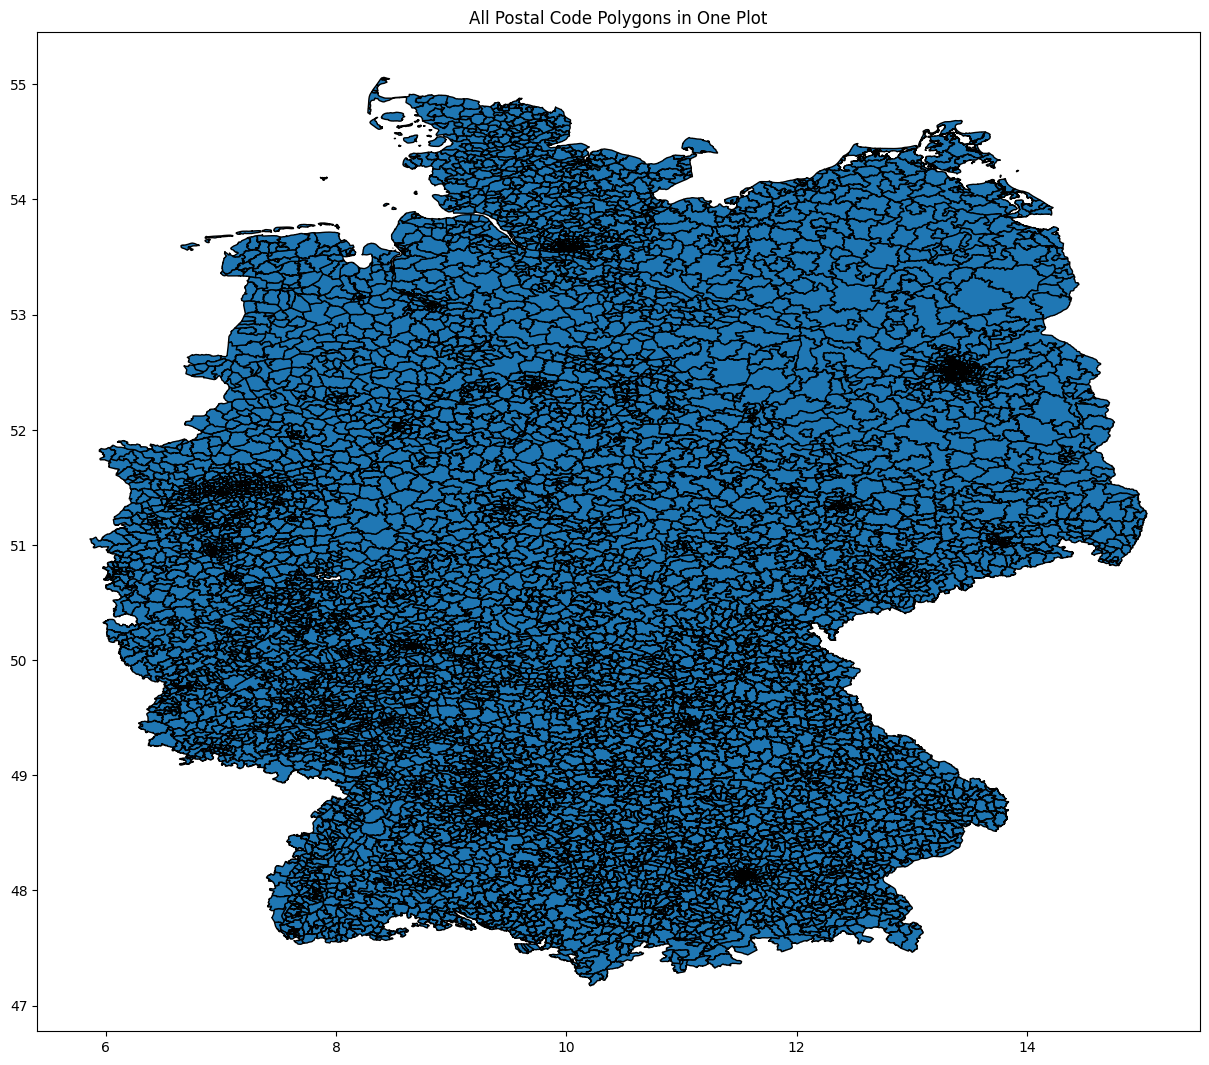

In [3]:
# Function to plot all postal code polygons in one plot
def plot_all_polygons_in_one(gdf, crs):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("All Postal Code Polygons in One Plot")

    # Set the CRS for the GeoDataFrame
    gdf.crs = crs

    # Plot all the polygons in one plot
    gdf.to_crs(crs).plot(ax=ax, edgecolor='k')

    plt.show()

# Extract all geometries from the dictionary and create a GeoDataFrame
def create_combined_gdf_from_dict(place_postal_code_polygons):
    geometries_all = [geometry for geometries in place_postal_code_polygons.values() for geometry in geometries]
    postal_codes_all = [postal_code for postal_code in place_postal_code_polygons.keys() for _ in place_postal_code_polygons[postal_code]]

    return gpd.GeoDataFrame(geometry=geometries_all, data={'postal_code': postal_codes_all})

# Example usage
gdf_germany_all = create_combined_gdf_from_dict(place_postal_code_polygons_germany)

# Specify the desired CRS (EPSG:25832)
crs_germany = "EPSG:25832"

# Plot all postal code polygons in one plot
plot_all_polygons_in_one(gdf_germany_all, crs_germany)
